# DM-electron scattering rates in semiconductors

### This is to test that we can reproduce the rate calculation from the QEDark webpage and try to match the plots from https://arxiv.org/abs/1509.01598

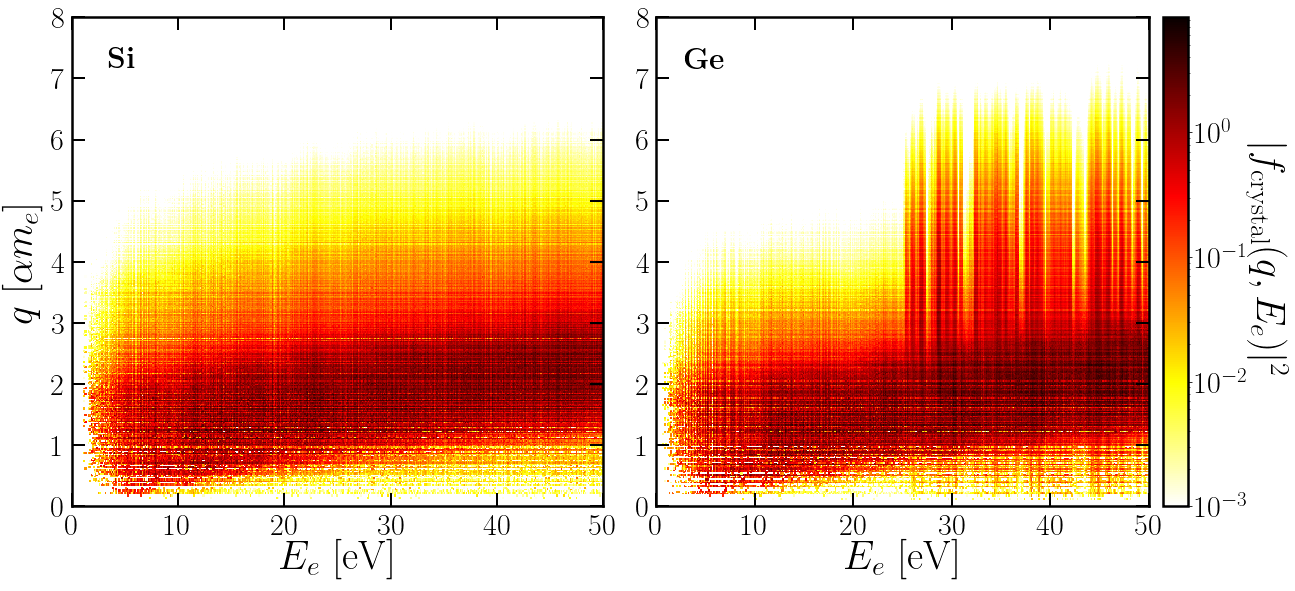

In [3]:
import sys
sys.path.append('../erec')
from numpy import *
import matplotlib.pyplot as plt
from LabFuncs import *
from Params import *
from DMFuncs import *
from PlotFuncs import *
from HaloFuncs import *
from Params import *
from AtomicFuncs import *
import matplotlib.colors as colors
import cmocean

%matplotlib inline

dq = 0.02
de = 0.1
ne = 500
nq = 900

dat1 = loadtxt('../data/fion/Si_f2.dat')
dat1 = reshape(dat1,(ne,nq)).T

dat2 = loadtxt('../data/fion/Ge_f2.dat')
dat2 = reshape(dat2,(ne,nq)).T

qvals = linspace(dq/2.0,nq*dq-dq/2.0,nq)
evals = linspace(de/2.0,de*ne-de/2.0,ne)

fig,ax1,ax2 = MyDoublePlot(r'$E_e$ [eV]',r'$q$ [$\alpha m_e$]',r'$E_e$ [eV]','',wspace=0.1,size_y=9,tfs=30,lfs=40)

fmin = 1e-3
fmax = max(amax(dat2),amax(dat1))
ax1.pcolormesh(evals,qvals,dat1,norm=colors.LogNorm(vmin=fmin, vmax=fmax),cmap=cm.hot_r)
im = ax2.pcolormesh(evals,qvals,dat2,norm=colors.LogNorm(vmin=fmin, vmax=fmax),cmap=cm.hot_r)
ax2.set_ylim([0,8])
ax2.set_xlim([0,50])
ax1.set_ylim([0,8])
ax1.set_xlim([0,50])

cbar1 = cbar(im)
cbar1.set_label(r'$|f_{\rm crystal}(q,E_e)|^2$',fontsize=40,rotation=-90,labelpad=40)

plt.gcf().text(0.15,0.8,r'{\bf Si}',fontsize=30)
plt.gcf().text(0.55,0.8,r'{\bf Ge}',fontsize=30)


plt.show()

# As is, the table seems to match their Fig. 5, although there seem to be some strange artefacts across certain $q$ bins. Not sure whether to worry about these or not. They don't show up in their plot, I think this might be because they have summed over neighbouring bins or something, see below

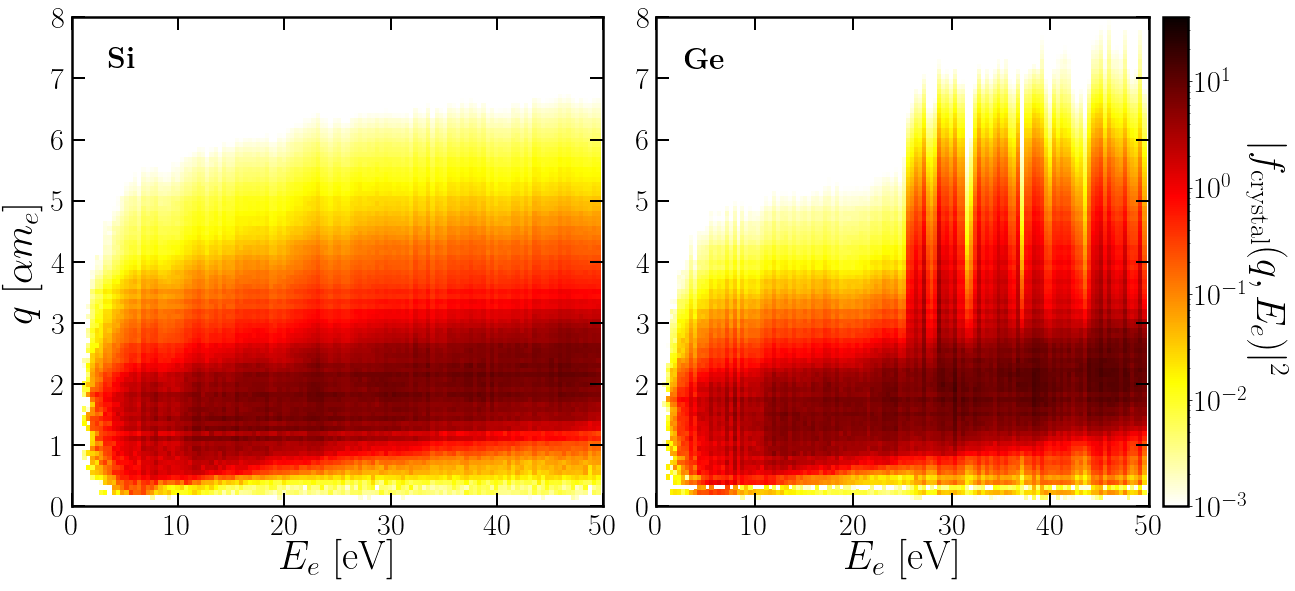

In [4]:
fig,ax1,ax2 = MyDoublePlot(r'$E_e$ [eV]',r'$q$ [$\alpha m_e$]',r'$E_e$ [eV]','',wspace=0.1,size_y=9,tfs=30,lfs=40)


def shrink(data, rows, cols):
    return data.reshape(rows, int(data.shape[0]/rows), cols, int(data.shape[1]/cols)).sum(axis=1).sum(axis=2)

redf = 4
dq_c = 0.02*redf
de_c = 0.1*redf
ne_c = int(500/redf)
nq_c = int(900/redf)
qvals_c = linspace(dq_c/2.0,nq_c*dq_c-dq_c/2.0,nq_c)
evals_c = linspace(de_c/2.0,de_c*ne_c-de_c/2.0,ne_c)
dat1_c = shrink(dat1,nq_c,ne_c)/redf
dat2_c = shrink(dat2,nq_c,ne_c)/redf

fmin = 1e-3
fmax = 40.0
ax1.pcolormesh(evals_c,qvals_c,dat1_c,norm=colors.LogNorm(vmin=fmin, vmax=fmax),cmap=cm.hot_r)
im = ax2.pcolormesh(evals_c,qvals_c,dat2_c,norm=colors.LogNorm(vmin=fmin, vmax=fmax),cmap=cm.hot_r)
ax2.set_ylim([0,8])
ax2.set_xlim([0,50])
ax1.set_ylim([0,8])
ax1.set_xlim([0,50])

cbar1 = cbar(im)
cbar1.set_label(r'$|f_{\rm crystal}(q,E_e)|^2$',fontsize=40,rotation=-90,labelpad=40)

plt.gcf().text(0.15,0.8,r'{\bf Si}',fontsize=30)
plt.gcf().text(0.55,0.8,r'{\bf Ge}',fontsize=30)

plt.show()

# Which looks a bit more like theirs

### This is just a short bit to convert their table into a square array so that it matches the way I am treating the other ionisation form factors. I prefer having them be square because it removes the possibility for others to have errors when reshaping the arrays

In [ ]:
# This is just to convert the table into a square so 
# that it matches the way I am treating the other ionisation form factors

dq = (900*0.02*alph*m_e)/(1.0*ne)

qfine = linspace(dq/2.0,ne*dq-dq/2.0,ne)
Efine = evals
F1 = zeros(shape=(ne,ne))
F2 = zeros(shape=(ne,ne))
for i in range(0,ne):
    F1[i,:] = interp(qfine,qvals*alph*m_e,dat1[:,i])
    F2[i,:] = interp(qfine,qvals*alph*m_e,dat2[:,i])

savetxt('../data/fion/fion_Si.txt',vstack((Efine/1000.0,qfine,log10(F1))),delimiter='\t',fmt="%1.16f")
savetxt('../data/fion/fion_Ge.txt',vstack((Efine/1000.0,qfine,log10(F2))),delimiter='\t',fmt="%1.16f")


# Next let's try and reproduce their rate. This is exactly copying the mathematica file. I will then try and explain what I think doesn't make sense.

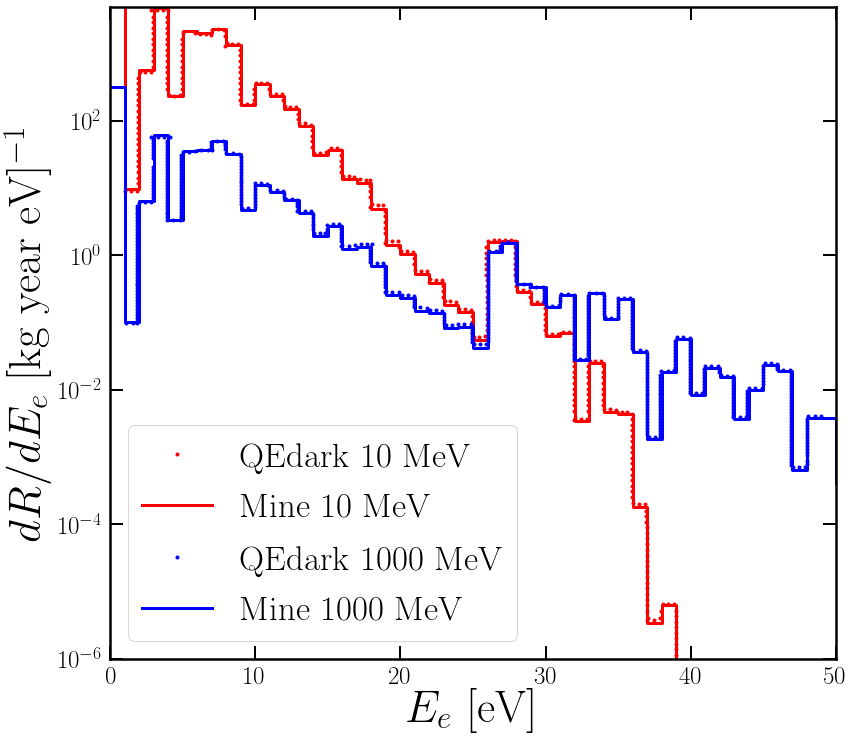

In [6]:
nq = 1000 # accuracy of q integral
nevals = 51 # number of energies
nv = 1000 # number of v_mins

sigma_e = 1.0e-37 # cm^2
E_r_vals = linspace(0.000,50.0,nevals) # energy bin edges in eV
m_e_eV = m_e*1000.0 # electron mass in eV

# Load in their form factor again
ne = 500 # number of energies
nq = 900 # number of momenta
fion_fine = loadtxt('../data/fion/Ge_f2.dat')
fion_fine = reshape(fion_fine,(ne,nq))
dq = 0.02*alph*m_e_eV # q binwidth in eV
dE = 0.1 # energy binwidth in eV
qfine = linspace(dq/2.0,nq*dq-dq/2.0,nq) # array of momenta bin centers
Efine = linspace(dE/2.0,dE*ne-dE/2.0,ne) # array of energy bin centers

# Define gmin exactly how they have 
def gmin0(v_min):
    v_esc = 600.0
    v_e = 240.0
    v0 = 230.0
    sig = v0/sqrt(2.0)
    N_esc = Nesc_Isotropic(sig,v_esc)
    x = v_min/v0
    z = v_esc/v0
    y = v_e/v0
    gvmin = zeros(shape=shape(v_min))
    g2 = (1.0/(2.0*N_esc*v0*y))*(erf(x+y)-erf(x-y)-(4.0/sqrt(pi))*y*exp(-z**2))
    g3 = (1.0/(2.0*N_esc*v0*y))*(erf(z)-erf(x-y)-(2.0/sqrt(pi))*(y+z-x)*exp(-z**2))
    gvmin[(x<abs(y-z))&(z>y)] = g2[(x<abs(y-z))&(z>y)]
    gvmin[(abs(y-z)<x)&(x<(y+z))] = g3[(abs(y-z)<x)&(x<(y+z))]
    return gvmin/(1000*100) # output in cm^-1 s


# Constants
rho0 = 0.4*1e9 # local density in eV cm^-3
Mtarget = 1.0 # target mass (1.0 means rate is in per target mass units)
Mcell = 2*72.64*m_p_kg # cell mass is 2*m_N which is converted into kg



# The factors I don't understand:
Eprefactor = 1.8 # in eV, this factor is included
wk = 2.0*alph # this factor I assume comes from the k-discretisation but why it needs to be here and is not already a


def QEDark_RateTest(m_DM): # DM mass in MeV
    m_DM_eV = m_DM*1e6 # DM mass in eV
    mu = m_e_eV*m_DM_eV/(m_e_eV+m_DM_eV) # reduced mass in eV
    dR = zeros(shape=nevals)
    for i in range(0,nevals):
        E_r = E_r_vals[i]

        # First work out which vmin values need to be used
        vmin_vals = vmin_ER(0.0,E_r/1000.0,qfine/1000.0,m_DM)

        # calculate gmin (which they call eta)
        eta = gmin0(vmin_vals)


        # Now the rate, calculate exactly as they do:
        dR[i] = (c_cm**2.0)*seconds2year*(rho0/m_DM_eV)*(Mtarget/Mcell)*sigma_e*(alph*m_e_eV**2.0/mu**2.0)\
                *sum((dE*dq/qfine)*eta*Eprefactor/(dq*dE)*(wk/2.0)*(wk/2.0)*(1.0/wk)*fion_fine[int(floor(E_r/dE)-1),:])
    #dR /= E_r_vals
    return dR
    
# Plot this rate alongside theirs to double check
fig,ax1 = MySquarePlot(r'$E_e$ [eV]',r'$dR/dE_e$ [kg year eV]$^{-1}$')

dat3 = loadtxt('../data/rates/QEDarkRate_10MeV.txt',delimiter=',')
plt.plot(dat3[:,1],dat3[:,0],'r.',label='QEdark 10 MeV')
plt.step(E_r_vals,QEDark_RateTest(10.0)*2,'r-',lw=3,where='post',label='Mine 10 MeV')
         
dat4 = loadtxt('../data/rates/QEDarkRate_1000MeV.txt',delimiter=',')
plt.plot(dat4[:,0],dat4[:,1],'b.',label='QEdark 1000 MeV')
plt.step(E_r_vals,QEDark_RateTest(1000.0)*2,'b-',lw=3,where='post',label='Mine 1000 MeV')      
         
plt.legend(fontsize=35)

plt.yscale('log')
plt.xlim([0,50])
plt.ylim([1.0e-6,5000])
plt.show()

# Matches up with them pretty much exactly, *up to a factor of 2??* I can't seem to find where that factor is coming from


## But even ignoring that factor for now, if we look at how they calculated the rate some things don't seem to make sense:

Firstly to compute the integral they sum over $\frac{1}{q}g(v_{\rm min})|f_{\rm crystal}(E_r,q)|^2$. However the integral (Eq. 3.13) from their paper is $\sim\int d \ln q \frac{1}{q} g(v_{\rm min}) |f_{\rm crystal}(E_r,q)|^2$.

So shouldn't they be summing with an extra $1/q$?

Also if you check their dimensions, you find that this rate should come out in units of (kg yr)$^{-1}$. Not (kg yr eV)$^{-1}$ as they present in the plot.

The only way to reconcile the dimensions seems to be if $|f_{\rm crystal}|^2$ has dimensions of inverse energy. It should be dimensionless, but even if for some reason they had divided by the binsize, this would give it dimensions of inverse energy squared... Similarly, I don't understand is why they need divide by $E_r$ and $q$ binwidths and then multiply by them in the same line. Presumably the table they provide is the binned averaged one? Surely one should only need one factor of $\Delta q$ to compute the $q$ integral.

They also include these mysterious factors of $\frac{1}{2} w_k \frac{1}{2} w_k \frac{1}{w_k}$ and $2\pi^2 (\alpha m^2_e V_{\rm cell})^{-1} = 1.9$ eV. But from reading Sec. 4.2, why are these not already taken into account in the definition of $f_{\rm crystal}$?

Curiously when I attempt the calculation from the formula in the paper and taking I get a result which is very close to theirs, but I do not have any of these factors. I merely take $|f_{\rm crystal}|$ to be what it is advertised to be.

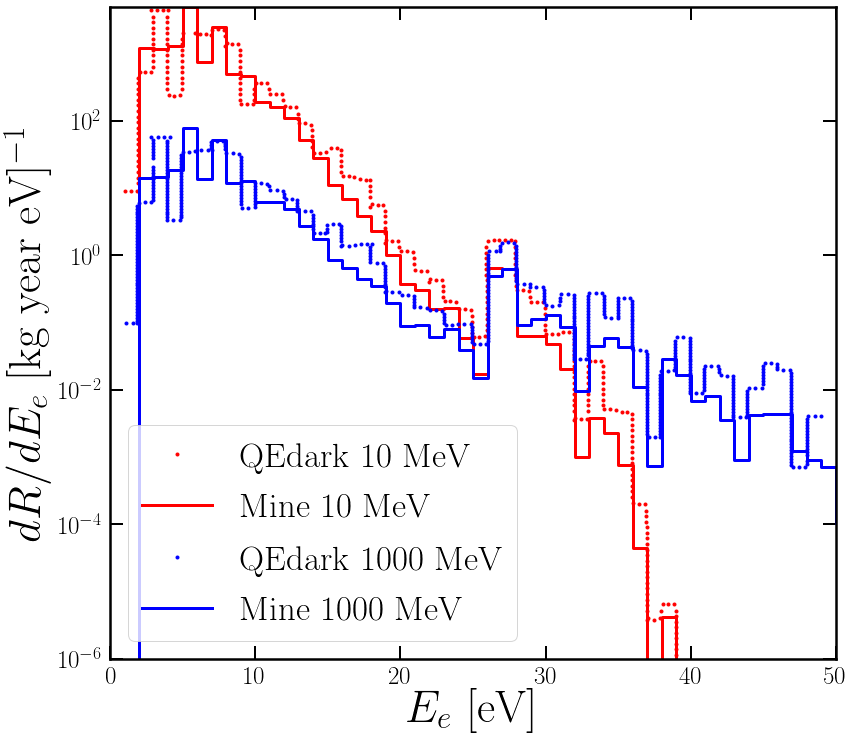

In [49]:
# my code all works in keV:
E_r_vals = linspace(0.0001,50.0,nevals)/1000.0 # energy bin edges in keV
x = E_r_vals*1000.0

def ElectronRecoilRate_Semiconductor(Atom,E_r_vals,m_DM,sigma_e,DMFormFactor,\
                    vmin_fine,gmin_fine,rho_0=SHMpp.LocalDensity,nq=20):

    E_B_vals = Atom.BindingEnergies/1000.0
    Vfactor = alph*Atom.VCellFactor/1000.0

    nsh = size(E_B_vals)

    Efine,qfine,fion_fine = Atom.IonisationFormFactor()
    de = (Efine[1]-Efine[0])
    dq = qfine[1]-qfine[0]
    
    # Constants
    m_DM_keV = m_DM*1000 # keV
    ne = size(E_r_vals)
    m_N_kg = Atom.MassNumber*m_p_kg # keV
    N_T = 1.0/(2*m_N_kg) # kg factor of 2 from the fact we have two cells per nucleus
    mu = m_DM_keV*m_e/(m_e+m_DM_keV) # keV
    n_DM = rho_0*1e6/m_DM_keV # cm**-3.0

    
    vmax = 850.0/c_km # natural units

    if ndim(gmin_fine)>1:
        nt = shape(gmin_fine)[0]
    else:
        nt = 1
        gmin_fine = reshape(gmin_fine,(1,size(gmin_fine)))

    dRdlnE = zeros(shape=(nt,ne))

    for it in range(0,nt):
        Emax = 0.5*m_DM_keV*vmax**2.0
        if Emax>E_r_vals[0]:
            imax = arange(0,ne)[E_r_vals<Emax][-1]
            for i in range(0,imax+1): # over energies
                E_r = E_r_vals[i]
                
                # Form factor
                qmax = min(m_DM_keV*vmax*(1.0+sqrt(1-2*(E_r)/(m_DM_keV*vmax**2.0))),qfine[-1])
                qmin = max(m_DM_keV*vmax*(1.0-sqrt(1-2*(E_r)/(m_DM_keV*vmax**2.0))),qfine[0])
                qvals = linspace(qmin,qmax,nq)
                fion = interp(qvals,qfine,fion_fine[argmin(abs(E_r-Efine)),:,0])

                # interpolate at required vmin and calculate cross section
                vmin_vals = vmin_ER(0.0,E_r,qvals,m_DM)
                gmin = interp(vmin_vals,vmin_fine,gmin_fine[it,:])/(1000*100)
                qfunc = E_r*fion*gmin*DMFormFactor(qvals)/qvals
                dsigma = (c_cm)**2*(sigma_e*m_e**2.0*alph/(mu**2.0))*trapz(qfunc,log(qvals)) # cm^3

                # rate
                dRdlnE[it,i] += dsigma*N_T*n_DM#*AtomicFuncs.FermiFactor(E_r) # kg^-1 s^-1
    dRdlnE *= seconds2year # kg^-1 yr^-1
    return squeeze(dRdlnE)

vmin = linspace(0.0,850.0,nv)
gmin = gmin0(vmin)*1000*100 # my code takes in gmin in km^-1 s


# Plot this rate alongside theirs
fig,ax1 = MySquarePlot(r'$E_e$ [eV]',r'$dR/dE_e$ [kg year eV]$^{-1}$')

plt.plot(dat3[:,1],dat3[:,0],'r.',label='QEdark 10 MeV')
R = ElectronRecoilRate_Semiconductor(Ge,E_r_vals,10.0,sigma_e,HeavyMediator,vmin,gmin,nq=nq,rho_0=0.4)
plt.step(x,R/x,'r-',lw=3,where='post',label='Mine 10 MeV')
         
plt.plot(dat4[:,0],dat4[:,1],'b.',label='QEdark 1000 MeV')
R = ElectronRecoilRate_Semiconductor(Ge,E_r_vals,1000.0,sigma_e,HeavyMediator,vmin,gmin,nq=nq,rho_0=0.4)
plt.step(x,R/x,'b-',lw=3,where='post',label='Mine 1000 MeV')      
         
plt.legend(fontsize=35)

plt.yscale('log')
plt.xlim([0,50])
plt.ylim([1.0e-6,5000])
plt.show()

# This is extremely close to their result but seems to have some systematic discrepancy which increases towards larger $E_e$

How is it possible that I can almost reproduce their result but without any of these strange factors which show up in their code?

# Another thing to try is the rate as a function of number of electrons (still need to clean this up a bit)

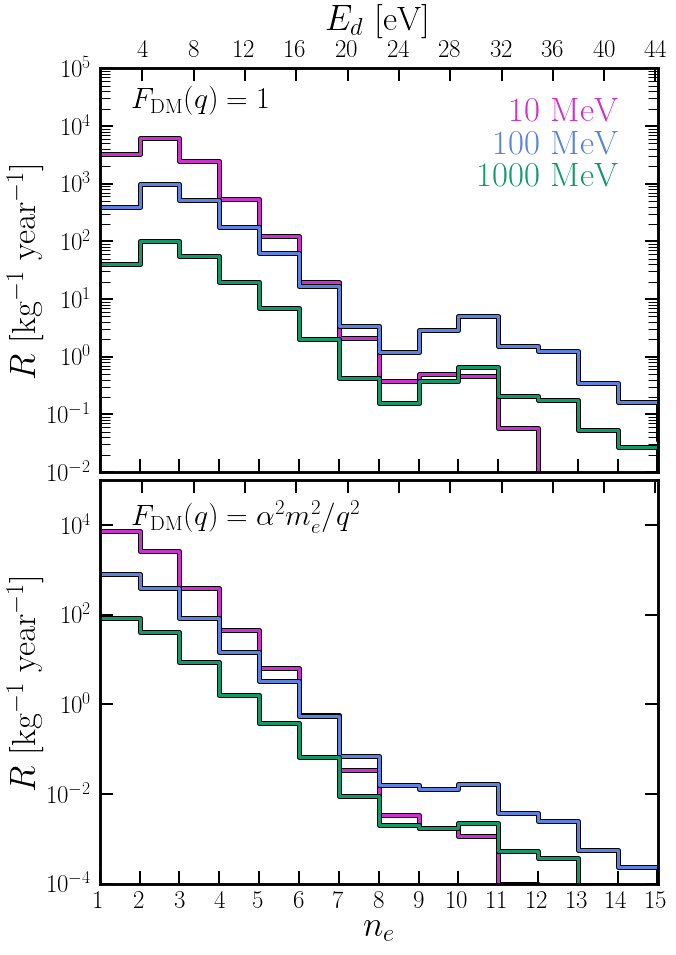

In [59]:
#####
E_gap = 0.67
eps = 2.9
def nelectrons(E_r,dRdlnE,E_gap,eps):
    Q = 1+floor((E_r*1000.0-E_gap)/eps)
    nmax = int(amax(Q))
    nmin = int(amin(Q))
    Rbin = zeros(shape=(nmax-nmin))
    Qvals = arange(nmin,nmax+1)
    nn = size(Qvals)-1
    for i in range(0,nn):
        mask = Q==Qvals[i]
        Rbin[i] = trapz(dRdlnE[mask]/E_r[mask],E_r[mask])
    return arange(nmin,nmax),Rbin
#####





#####
# set up plot
hspace=0.02
lw=2.5
lfs=35
tfs=25
size_x=10
size_y=15

xlab2 = r'$n_e$'
ylab2 = r'$R$ [kg$^{-1}$ year$^{-1}$]'
ylab1 = r'$R$ [kg$^{-1}$ year$^{-1}$]'
plt.rcParams['axes.linewidth'] = lw
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=tfs)
fig, axarr = plt.subplots(2, 1,figsize=(size_x,size_y))
gs = gridspec.GridSpec(2, 1)
gs.update(hspace=hspace)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=7)
ax1.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax2.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=7)
ax2.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax1.set_ylabel(ylab1,fontsize=lfs)
ax2.set_ylabel(ylab2,fontsize=lfs)
ax2.set_xlabel(xlab2,fontsize=lfs)
#####

  
col = cmocean.cm.phase(linspace(0,1,10))

nq = 1000
ne = 500
E_r_vals = linspace(0.67,50,ne)/(1000.0) # keV
    

R1_H = ElectronRecoilRate_Semiconductor(Ge,E_r_vals,10.0,sigma_e,HeavyMediator,vmin,gmin,nq=nq,rho_0=0.4)
R1_L = ElectronRecoilRate_Semiconductor(Ge,E_r_vals,10.0,sigma_e,LightMediator,vmin,gmin,nq=nq,rho_0=0.4)

R2_H = ElectronRecoilRate_Semiconductor(Ge,E_r_vals,100.0,sigma_e,HeavyMediator,vmin,gmin,nq=nq,rho_0=0.4)
R2_L = ElectronRecoilRate_Semiconductor(Ge,E_r_vals,100.0,sigma_e,LightMediator,vmin,gmin,nq=nq,rho_0=0.4)

R3_H = ElectronRecoilRate_Semiconductor(Ge,E_r_vals,1000.0,sigma_e,HeavyMediator,vmin,gmin,nq=nq,rho_0=0.4)
R3_L = ElectronRecoilRate_Semiconductor(Ge,E_r_vals,1000.0,sigma_e,LightMediator,vmin,gmin,nq=nq,rho_0=0.4)


Q1,Rbin1 = nelectrons(E_r_vals,R1_H,E_gap,eps)
Q2,Rbin2 = nelectrons(E_r_vals,R2_H,E_gap,eps)
Q3,Rbin3 = nelectrons(E_r_vals,R3_H,E_gap,eps)
ax1.step(Q1,Rbin1,'k',lw=5,where='post')
ax1.step(Q1,Rbin1,lw=3,color=col[3,:],where='post')
ax1.step(Q2,Rbin2,'k',lw=5,where='post')
ax1.step(Q2,Rbin2,lw=3,color=col[5,:],where='post')
ax1.step(Q3,Rbin3,'k',lw=5,where='post')
ax1.step(Q3,Rbin3,lw=3,color=col[7,:],where='post')

Q1,Rbin1 = nelectrons(E_r_vals,R1_L,E_gap,eps)
Q2,Rbin2 = nelectrons(E_r_vals,R2_L,E_gap,eps)
Q3,Rbin3 = nelectrons(E_r_vals,R3_L,E_gap,eps)
ax2.step(Q1,Rbin1,'k',lw=5,where='post')
ax2.step(Q1,Rbin1,lw=3,color=col[3,:],where='post')
ax2.step(Q2,Rbin2,'k',lw=5,where='post')
ax2.step(Q2,Rbin2,lw=3,color=col[5,:],where='post')
ax2.step(Q3,Rbin3,'k',lw=5,where='post')
ax2.step(Q3,Rbin3,lw=3,color=col[7,:],where='post')

nmax = 15
ax2.set_xticks(Q2)
ax1.set_xticks(Q1)
ax1.set_xticklabels([])

for tick in ax2.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("center")


plt.gcf().text(0.17,0.84,r'$F_{\rm DM}(q) = 1$',fontsize=30)
plt.gcf().text(0.17,0.45,r'$F_{\rm DM}(q) = \alpha^2 m^2_e/q^2$',fontsize=30)

plt.gcf().text(0.85,0.83,r'10 MeV',color=col[3,:],fontsize=35,ha='right')
plt.gcf().text(0.85,0.8,r'100 MeV',color=col[5,:],fontsize=35,ha='right')
plt.gcf().text(0.85,0.77,r'1000 MeV',color=col[7,:],fontsize=35,ha='right')

#ax1.set_xticks(Q1-0.5)
#ax2.set_xticks(Q1-0.5)
#ax2.set_xticklabels(Q1)

ax1.set_yscale('log')
ax1.set_ylim([1e-2,1e5])
ax2.set_yscale('log')
ax2.set_ylim([1e-4,1e5])
ax1.set_xlim([1,nmax])
ax1.set_xlim([1,nmax])
ax2.set_xlim([1,nmax])
ax2.set_xlim([1,nmax])

ax11 = ax1.twiny()
ax11.set_xticks(arange(0,48,4))
ax11.set_xlim([E_gap,nmax*eps+E_gap])
ax11.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=7)
ax11.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax11.set_xlabel('$E_d$ [eV]',fontsize=lfs)

ax11 = ax2.twiny()
ax11.set_xticks(arange(0,48,4))
ax11.set_xticklabels([])
ax11.set_xlim([E_gap,nmax*eps+E_gap])
ax11.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=7)
ax11.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)

plt.show()

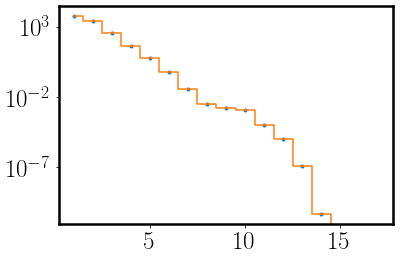

In [32]:
plt.semilogy(Q1,Rbin1,'.')
plt.step(Q1,Rbin1,where='mid')

In [42]:
nmax*eps+E_gap

44.17

In [67]:
(5*4*20*(100**3.0)*0.5)*1e9

2e+17